# Kaggle Mercedes Challenge

### Libraries

In [816]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
from sklearn import linear_model, decomposition
from math import log, exp
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from pandas.plotting import scatter_matrix
#from scipy import stats
#from scipy.special import boxcox, inv_boxcox



%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Data Import

In [817]:
train = pd.read_csv('./data/train.csv')
testing = pd.read_csv('./data/test.csv')

In [818]:
train.shape

(4209, 378)

In [819]:
testing.shape

(4209, 377)

In [820]:
##extract testing IDs for later use
testing_ID = testing['ID']

In [821]:
#cols = train.columns.values
#plot = 1 
#for col in cols:
#    plt.figure(plot)
#    plt.scatter(y= train['y'], x= train[col])
#    plt.title(col)
#    plot+=1

In [879]:
train.var()

ID         5.941938e+06
y          1.543594e+02
X0         2.307196e+02
X1         7.278049e+01
X2         1.357957e+02
X3         3.026986e+00
X4         5.462503e-03
X5         7.767869e+01
X6         8.506573e+00
X8         4.953066e+01
X10        1.313400e-02
X12        6.947230e-02
X13        5.463554e-02
X14        2.449075e-01
X15        4.751722e-04
X16        2.607855e-03
X17        7.548527e-03
X18        7.782555e-03
X19        8.948850e-02
X20        1.224538e-01
X21        2.607855e-03
X22        7.943103e-02
X23        2.025227e-02
X24        1.897977e-03
X26        4.966770e-03
X27        2.167418e-01
X28        3.150456e-02
X29        4.117295e-02
X30        4.495890e-03
X31        1.783131e-01
X32        1.104708e-02
X33        2.376426e-04
X34        5.437197e-03
X36        4.495890e-03
X38        3.217072e-02
X40        7.125888e-04
X41        1.127941e-02
X42        2.376426e-04
X43        6.704018e-02
X44        1.127941e-02
X45        1.891974e-01
X46        2.406

### Encode categorical variables and add features

In [822]:
##hack to prevent sorting of columns during append.
testing.insert(1,'y','0')
testing['y'] = testing['y'].astype('float64')

## combine data for label encoding
all_data = train.append(testing,ignore_index=True)

In [823]:
## columns to encode
to_encode = ['X0','X1','X2','X3','X4','X5','X6','X8']
le = {}


for column in to_encode:
    le[column] = LabelEncoder()
    le[column].fit(all_data[column])
    all_data[column] = le[column].transform(all_data[column])

#### add features

In [824]:
##sum all apparent option columns to see if this is a valuable feature

#cols_to_sum = all_data.columns.values
#cols_to_sum = np.delete(cols_to_sum,list(range(0,10)))
#all_data = all_data.assign(option_sum = all_data[cols_to_sum].sum(axis=1))

In [825]:
##Create empty column and extract index
#all_data['option_sumb'] = 'NaN'
#all_index = all_data.index.values
#all_col = all_data.columns.values[10:324]

##Gather bits into a string and add to df
#for idx in all_index:
#    gather = all_data[col][idx].astype('int').astype('str')
    
#    for col in all_col:
#        gather+=all_data[col][idx].astype('int').astype('str')
    
#    all_data['option_sumb'][idx] = gather
    
    
##Categorize it to remove any bias based on the decimal value
#le_sumb = LabelEncoder()
#le_sumb.fit(all_data['option_sumb'])
#all_data['option_sumb'] = le_sumb.transform(all_data['option_sumb'])

#### looking at gap in IDs

In [826]:
#all_data_ID = all_data['ID']
#shift_all_data_ID = all_data_ID.drop(all_data_ID.index[0],)

#shift_ID = pd.Series([8417])
#all_data['ID_gap'] = (shift_all_data_ID.append(shift_ID, ignore_index=True) - all_data_ID)

#### drop zero variance columns

In [827]:
##identify columns with 0 variance in train data
var_train = pd.DataFrame(train.var(),columns=['variance']).reset_index()
remove_train = var_train[var_train['variance']==0]['index'].as_matrix()

##identify columns with 0 variance in testing data
var_testing = pd.DataFrame(testing.var(),columns=['variance']).reset_index()
remove_testing = var_testing[var_testing['variance']==0]['index'].as_matrix()
##remove y from list
ind = np.argwhere(remove_testing=='y')
remove_testing = np.delete(remove_testing, ind)

##Drop columns with 0 variance in either train or test
all_data.drop(remove_train, axis=1, inplace=True)
all_data.drop(remove_testing, axis=1, inplace=True)

#### drop duplicate columns

In [828]:
all_data = all_data.T.drop_duplicates().T

#### complementary columns

In [829]:
all_columns = all_data.columns.values
to_drop = []

for col in all_columns:
    
    if col in to_drop:
        continue
        
    ind = np.argwhere(all_columns==col)
    compare_columns = np.delete(all_columns, ind)
    complimentary_columns = []
    
    for comp in compare_columns:
        
        uniq = all_data[[col,comp]].sum(axis=1).nunique()
    
        if uniq==1:
            complimentary_columns.append(comp)
            to_drop.append(comp)
    #print (col, complimentary_columns,sep=':')
           
  
all_data.drop(to_drop, axis=1, inplace=True)   

#### remove high correlation variables

In [384]:
corr_threshold = .8

all_columns = all_data.columns.values
to_drop = []

for feat1 in all_columns:
    
    if feat1 in to_drop:
        continue
        
    ind = np.argwhere(all_columns==feat1)
    features_to_corr = np.delete(all_columns, ind)
    correlated_features = []
    
    for feat2 in features_to_corr:
        
        pcorr, pvalue = pearsonr(all_data[feat1], all_data[feat2] )
    
        if pcorr > corr_threshold:
            correlated_features.append(feat2)
            to_drop.append(feat2)
            pcorr2, pvalue2 = pearsonr(all_data[feat2], all_data['y'])
            print (pcorr2, pvalue2, sep=':')

    print (feat1, correlated_features, sep=':')
           
  
#all_data.drop(to_drop, axis=1, inplace=True)   

ID:[]
y:[]
X0:[]
X1:[]
X2:[]
X3:[]
X4:[]
X5:[]
X6:[]
X8:[]
X10:[]
X12:[]
X13:[]
0.0190022156163:0.0812733173014
0.0244030823308:0.0251575171097
X14:['X191', 'X251']
-0.00840436251449:0.440709003787
X15:['X260']
X16:[]
-0.0155417625123:0.153918640702
X17:['X325']
X18:[]
-0.0386129152081:0.000394827681872
X19:['X215']
X20:[]
X21:[]
X22:[]
X23:[]
X24:[]
X26:[]
X27:[]
-0.0131062550328:0.229221175196
X28:['X148']
-0.0377941189543:0.000523720010173
-0.0321289676786:0.00319686930015
-0.0252342513015:0.0205987736501
-0.0397392763164:0.000265356950993
-0.0379314157452:0.000499675531533
-0.0384879040417:0.000412372764379
-0.036718006455:0.000753045646236
X29:['X54', 'X162', 'X166', 'X232', 'X272', 'X276', 'X328']
X30:[]
X31:[]
X32:[]
X33:[]
X34:[]
X36:[]
X38:[]
X40:[]
X41:[]
X42:[]
X43:[]
0.0222621645436:0.0411023756531
X44:['X317']
0.00675775175625:0.535299643038
0.00769786795748:0.480074750083
0.00797283747829:0.464529908793
X45:['X161', 'X202', 'X247']
X46:[]
0.0169068700741:0.120882497453
X4

#### scale data

In [274]:
##remove target
#all_data_Y = all_data['y']
#all_data_X = all_data.drop('y', axis=1)

#scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(all_data_X)
#Scaled = pd.DataFrame(scaler.transform(all_data_X),columns=list(all_data_X))


##readd target
#Scaled['y']= all_data_Y
#all_data = Scaled

#### resplit data

In [830]:
## resplit the data
train = all_data[0:4209]
testing = all_data[4209:].drop('y', axis=1)

## drop ID
#train.drop('ID', inplace=True, axis=1)
#testing.drop('ID', inplace=True, axis=1)

In [687]:
#train.drop('ID', inplace=True, axis=1)
#testing.drop('ID', inplace=True, axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Correlation

In [744]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

In [269]:
#plot_corr(train,size=150)

In [745]:
pcorr = pd.DataFrame()
for feat in train:
    pcorr[feat] = pearsonr(train[feat], train['y'] )

pcorr = pcorr.T
pcorr.columns = ['corr','pvalue']
pcorr['corr'] = abs(pcorr['corr'])
pcorr.sort_values('corr', inplace=True, ascending=False)

In [747]:
top_pcorr = pcorr[:100].index.values
##remove y from list
ind = np.argwhere(top_pcorr=='y')
top_pcorr = np.delete(top_pcorr, ind)

In [748]:
top_pcorr

array(['X314', 'X261', 'X127', 'X232', 'X29', 'X54', 'X136', 'X328',
       'X276', 'X162', 'X272', 'X313', 'X166', 'X250', 'X178', 'X275',
       'X118', 'X234', 'X316', 'X378', 'X28', 'X185', 'X348', 'X80', 'X51',
       'X264', 'X126', 'X179', 'X108', 'X286', 'X128', 'X371', 'X311',
       'X304', 'X159', 'X66', 'X111', 'X101', 'X191', 'X251', 'X14',
       'X198', 'X48', 'X43', 'X0', 'X315', 'X61', 'X148', 'X306', 'X98',
       'X224', 'X52', 'X120', 'X215', 'X19', 'X170', 'X223', 'X274',
       'X187', 'X273', 'X300', 'X17', 'X156', 'X3', 'X68', 'X71', 'X256',
       'X75', 'X46', 'X325', 'X354', 'X180', 'option_sum', 'X155', 'X229',
       'X228', 'X150', 'X355', 'X241', 'X301', 'X115', 'X96', 'X343',
       'X189', 'X238', 'X132', 'X376', 'X47', 'X363', 'X169', 'X85',
       'X255', 'X151', 'X171', 'X208', 'X331', 'X209', 'X368', 'X367'], dtype=object)

### Mutual information

In [273]:
#mtrain = train.drop('y', axis=1)
#minfo = mutual_info_regression(mtrain, train.y.values)

#minfoFrame = pd.DataFrame({'feature':list(mtrain), 'minfo':minfo})
#minfoSorted = minfoFrame.sort_values(by='minfo', ascending=False)
#minfoSorted



In [274]:
#m_top = minfoSorted.feature.values[:20]
#m_top_y = np.append(m_top,'y')
#testing = testing[m_top]
#train = train[m_top_y]


### Split out validation data

remove y outliers

In [806]:
train['y'].sort_values(ascending=False)

883     265.32
342     169.91
1459    167.45
3133    165.52
1203    160.87
889     158.53
2735    158.23
3744    155.62
429     154.87
1060    154.43
2240    154.16
2736    153.51
1269    152.32
1205    150.89
253     150.43
1141    149.63
4176    149.52
2376    148.94
681     147.72
2905    147.22
216     146.83
3090    146.30
2887    144.56
1036    144.36
1349    142.71
2357    142.71
3980    142.46
2852    141.39
900     141.31
3215    141.09
846     140.49
1033    140.41
3028    140.31
2348    140.25
995     140.15
1730    139.61
43      139.20
2983    139.16
1279    139.08
3442    139.07
2888    138.19
2470    137.49
998     137.44
3177    137.32
2496    137.09
2263    136.96
3773    136.75
2414    136.56
420     136.47
203     136.41
2447    135.53
3358    135.48
1427    135.29
2530    135.14
3165    135.13
2375    134.81
227     134.43
523     134.26
1272    134.21
2280    134.08
1308    134.04
3151    133.86
1712    133.55
1627    133.50
1237    133.36
2555    133.09
1667    13

In [831]:
train = train.drop(train[train['y']>200].index)

In [275]:
##feature limiting based on various methods
#top_feat_y = np.append(top_feat,'y')
#testing = testing[top_feat]
#train = train[top_feat_y]

#top_pcorr_y = np.append(top_pcorr,'y')
#testing = testing[top_pcorr]
#train = train[top_pcorr_y]

In [832]:
#train.loc[:,'y'] = train['y'].apply(log)


##Dived up the data into training and validation sets
training, validation = train_test_split(train, test_size = 0.2,random_state=42)

##Add X0 mean feature for testing
X0_mean_dict = training.groupby(by='X0').mean()['y'].to_dict()

training_index = training.index.values
validation_index = validation.index.values
training.loc[:,'X0_mean'] = 'NaN'
validation.loc[:,'X0_mean'] = 'NaN'

for idx in training_index:
    training.loc[idx, 'X0_mean'] = X0_mean_dict[training.loc[idx,'X0']] 
    
for idx in validation_index:
    validation.loc[idx,'X0_mean'] = X0_mean_dict[validation.loc[idx,'X0']]
    
training.loc[:,'X0_mean'] = pd.to_numeric(training.loc[:,'X0_mean'])
validation.loc[:,'X0_mean'] = pd.to_numeric(validation.loc[:,'X0_mean'])


training_Y = training['y']
training_X = training.drop('y', axis=1)

validation_Y = validation['y']
validation_X = validation.drop('y', axis=1)


/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### XGBoost

In [852]:
validation_X.drop('X136',axis=1,inplace=True)

In [853]:
##Create train and validate DMatrix
trainingXGB = xgb.DMatrix(training_X, label=training_Y)
validateXGB = xgb.DMatrix(validation_X)



### Finding best hyperparameters

In [2266]:
##Set up crossvalidation and build model to test.  
ind_params = {'nthread':3}
cv_params = {'max_depth':[2],
             'min_child_weight':[8],
             'gamma':[0],
             'subsample':[1],
             'colsample_bytree':[.9],
             'learning_rate':[.3], 
             'n_estimators':[26],
             'reg_alpha':[0]
              }
##Build optimized model with GridSearch
model_xgb = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                         cv_params, 
                         cv=10, 
                         n_jobs=3,
                         verbose=100,
                         scoring='r2')

model_xgb.fit(training_X, training_Y)

best_params = model_xgb.best_params_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to new file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
Pickling array (shape=(17

[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.587219, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    1.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:    1.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done  17 tasks      | elapsed:    2.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.635310, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.600500, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.567905, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done  28 tasks      | elapsed:    3.0s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.605292, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done  37 tasks      | elapsed:    3.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    4.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done  47 tasks      | elapsed:    4.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.638155, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.600771, total=   0.2s
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.554675, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done  58 tasks      | elapsed:    5.9s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.588512, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done  67 tasks      | elapsed:    6.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6, score=0.608215, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:    8.2s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int6

[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.639862, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.605455, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.565831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done  88 tasks      | elapsed:    9.1s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.604392, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done  97 tasks      | elapsed:   10.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 106 tasks      | elapsed:   10.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:   11.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.606000, total=   0.2s
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.642815, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.567907, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 118 tasks      | elapsed:   12.1s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.588808, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 127 tasks      | elapsed:   13.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

Pickling array (shape=(176,), dtype=object).[Parallel(n_jobs=3)]: Done 136 tasks      | elapsed:   14.0s

Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 137 tasks      | elapsed:   14.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.636239, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.598316, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.563957, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done 148 tasks      | elapsed:   15.3s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607815, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 157 tasks      | elapsed:   16.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 166 tasks      | elapsed:   17.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 167 tasks      | elapsed:   17.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.633126, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.606451, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.550249, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 178 tasks      | elapsed:   18.5s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.591752, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:   19.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 196 tasks      | elapsed:   20.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 197 tasks      | elapsed:   20.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.634552, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.59762

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.641183, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607586, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.569030, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 218 tasks      | elapsed:   23.5s
Pickling array (shape=(176,), dtype=object).
Pic

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.641542, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.602744, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.569242, total=   0.3s
[Parallel(n_jobs=3)]: Done 228 tasks      | elapsed:   24.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01f

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.637352, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.603255, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.559394, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 238 tasks      | elapsed:   25.9s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.589782, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
Pickling array (shape=(176,), dtype=object).[Parallel(n_jobs=3)]: Done 247 tasks      | elapsed:   27.2s

Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 256 tasks      | elapsed:   28.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 257 tasks      | elapsed:   28.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.634815, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.604556, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.562176, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done 268 tasks      | elapsed:   30.2s
Pickling array (shape=(176,), dtype=object).
Pic

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607709, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 277 tasks      | elapsed:   31.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 286 tasks      | elapsed:   33.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 287 tasks      | elapsed:   33.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.639565, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.603575, total=   0.3s
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.569738, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 298 tasks      | elapsed:   34.6s
Pickling array (shape=(176,), dtype=object).
Pickling array 

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.592760, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 307 tasks      | elapsed:   35.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
Pi

[Parallel(n_jobs=3)]: Done 316 tasks      | elapsed:   36.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 317 tasks      | elapsed:   37.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.628260, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.603294, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.561602, total=   0.3s
[Parallel(n_jobs=3)]: Done 328 tasks      | elapsed:   38.4s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.640033, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.605902, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.567906, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 338 tasks      | elapsed:   39.7s
Pickling array (shape=(176,), dtype=object).
Pickling array 

[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.605846, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[Parallel(n_jobs=3)]: Done 347 tasks      | elapsed:   40.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[Paral

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.604122, total=   0.3s
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.563948, total=   0.2s
[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:   42.1s finished


In [2300]:
#best_params['learning_rate'] = .01
best_params

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 8,
 'n_estimators': 696,
 'reg_alpha': 0,
 'subsample': 1}

In [64]:
#best_params = {'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 8,
 'n_estimators': 696,
 'reg_alpha': 0,
 'subsample': 1}

Looking for best number of rounds

In [2269]:
##Tune booster rounds

cvresult = xgb.cv(best_params, 
                  trainingXGB, 
                  nfold=10,  
                  num_boost_round=10000, 
                  early_stopping_rounds=50,
                  metrics='rmse',
                  verbose_eval=True)




best_params['n_estimators'] = len(cvresult)

[0]	train-rmse:99.9866+0.0948955	test-rmse:99.983+0.85586
[1]	train-rmse:98.9967+0.0942835	test-rmse:98.9929+0.855544
[2]	train-rmse:98.0167+0.0936648	test-rmse:98.0135+0.854902
[3]	train-rmse:97.0466+0.0929517	test-rmse:97.0436+0.85382
[4]	train-rmse:96.0861+0.092235	test-rmse:96.0832+0.853425
[5]	train-rmse:95.1354+0.0915114	test-rmse:95.1331+0.852583
[6]	train-rmse:94.1946+0.0910869	test-rmse:94.1917+0.852485
[7]	train-rmse:93.2631+0.0904713	test-rmse:93.2601+0.852096
[8]	train-rmse:92.3409+0.0898765	test-rmse:92.3379+0.852312
[9]	train-rmse:91.428+0.0895315	test-rmse:91.4249+0.852183
[10]	train-rmse:90.5243+0.0888865	test-rmse:90.5212+0.852445
[11]	train-rmse:89.6301+0.0876661	test-rmse:89.6265+0.853686
[12]	train-rmse:88.7445+0.0870171	test-rmse:88.7417+0.8533
[13]	train-rmse:87.8677+0.086417	test-rmse:87.8655+0.853106
[14]	train-rmse:86.9998+0.0861127	test-rmse:86.9973+0.852924
[15]	train-rmse:86.1406+0.0856898	test-rmse:86.1378+0.852801
[16]	train-rmse:85.2899+0.0855187	test-rms

[136]	train-rmse:26.9368+0.0892094	test-rmse:26.9186+1.1498
[137]	train-rmse:26.6959+0.0897499	test-rmse:26.6773+1.15425
[138]	train-rmse:26.4578+0.0901589	test-rmse:26.4389+1.15876
[139]	train-rmse:26.2222+0.090362	test-rmse:26.203+1.16353
[140]	train-rmse:25.9892+0.0909539	test-rmse:25.9694+1.16807
[141]	train-rmse:25.7588+0.0915591	test-rmse:25.7386+1.17266
[142]	train-rmse:25.5309+0.0921629	test-rmse:25.5101+1.17729
[143]	train-rmse:25.3057+0.0928593	test-rmse:25.2845+1.18165
[144]	train-rmse:25.0829+0.0934085	test-rmse:25.0614+1.18627
[145]	train-rmse:24.8625+0.0940365	test-rmse:24.8406+1.19094
[146]	train-rmse:24.6447+0.0945962	test-rmse:24.6224+1.19556
[147]	train-rmse:24.4292+0.0951638	test-rmse:24.4065+1.2003
[148]	train-rmse:24.2164+0.0954841	test-rmse:24.193+1.20528
[149]	train-rmse:24.0059+0.0961917	test-rmse:23.9821+1.20993
[150]	train-rmse:23.7977+0.0968219	test-rmse:23.7735+1.21468
[151]	train-rmse:23.5918+0.0974544	test-rmse:23.5672+1.21939
[152]	train-rmse:23.3882+0.09

[274]	train-rmse:10.6972+0.191316	test-rmse:10.5888+1.78052
[275]	train-rmse:10.6584+0.191881	test-rmse:10.5493+1.78334
[276]	train-rmse:10.6202+0.192578	test-rmse:10.5107+1.78603
[277]	train-rmse:10.5826+0.193116	test-rmse:10.4722+1.7885
[278]	train-rmse:10.5457+0.193682	test-rmse:10.4348+1.79116
[279]	train-rmse:10.5093+0.194232	test-rmse:10.3978+1.79366
[280]	train-rmse:10.4734+0.194733	test-rmse:10.3615+1.79622
[281]	train-rmse:10.4382+0.195448	test-rmse:10.3255+1.79869
[282]	train-rmse:10.4035+0.195989	test-rmse:10.2905+1.8009
[283]	train-rmse:10.3695+0.196536	test-rmse:10.2559+1.80326
[284]	train-rmse:10.336+0.197061	test-rmse:10.2216+1.80558
[285]	train-rmse:10.303+0.197704	test-rmse:10.1883+1.8079
[286]	train-rmse:10.2706+0.198252	test-rmse:10.1554+1.80994
[287]	train-rmse:10.2387+0.198896	test-rmse:10.123+1.81209
[288]	train-rmse:10.2073+0.199355	test-rmse:10.091+1.81421
[289]	train-rmse:10.1763+0.199984	test-rmse:10.0593+1.81632
[290]	train-rmse:10.146+0.200481	test-rmse:10.0

[412]	train-rmse:8.61577+0.230923	test-rmse:8.49466+1.87517
[413]	train-rmse:8.61216+0.230953	test-rmse:8.49135+1.87501
[414]	train-rmse:8.60869+0.231027	test-rmse:8.48814+1.87488
[415]	train-rmse:8.60515+0.231145	test-rmse:8.48465+1.87447
[416]	train-rmse:8.60181+0.231191	test-rmse:8.48154+1.87421
[417]	train-rmse:8.59848+0.231244	test-rmse:8.47844+1.87378
[418]	train-rmse:8.59528+0.231333	test-rmse:8.47546+1.87371
[419]	train-rmse:8.59198+0.231376	test-rmse:8.4724+1.87358
[420]	train-rmse:8.58882+0.231415	test-rmse:8.46938+1.87329
[421]	train-rmse:8.58574+0.23147	test-rmse:8.46641+1.87298
[422]	train-rmse:8.58261+0.231492	test-rmse:8.4635+1.87285
[423]	train-rmse:8.57959+0.231553	test-rmse:8.46062+1.87264
[424]	train-rmse:8.57659+0.231594	test-rmse:8.45802+1.87247
[425]	train-rmse:8.57372+0.231723	test-rmse:8.45523+1.87205
[426]	train-rmse:8.57081+0.231738	test-rmse:8.45254+1.87161
[427]	train-rmse:8.56797+0.231752	test-rmse:8.44999+1.87124
[428]	train-rmse:8.56527+0.231827	test-rmse

[550]	train-rmse:8.40954+0.233947	test-rmse:8.32789+1.83954
[551]	train-rmse:8.40899+0.233961	test-rmse:8.32756+1.83944
[552]	train-rmse:8.40843+0.233982	test-rmse:8.32758+1.83936
[553]	train-rmse:8.40794+0.233962	test-rmse:8.32741+1.83912
[554]	train-rmse:8.40732+0.233938	test-rmse:8.32729+1.83875
[555]	train-rmse:8.40681+0.233973	test-rmse:8.32701+1.83872
[556]	train-rmse:8.40626+0.233907	test-rmse:8.32668+1.83858
[557]	train-rmse:8.40576+0.233881	test-rmse:8.32645+1.83831
[558]	train-rmse:8.40522+0.233851	test-rmse:8.32632+1.83826
[559]	train-rmse:8.40472+0.233859	test-rmse:8.32615+1.83812
[560]	train-rmse:8.40419+0.233895	test-rmse:8.32598+1.83794
[561]	train-rmse:8.40368+0.233834	test-rmse:8.32579+1.83773
[562]	train-rmse:8.40321+0.233817	test-rmse:8.3257+1.83754
[563]	train-rmse:8.40276+0.233848	test-rmse:8.32558+1.83748
[564]	train-rmse:8.40225+0.233847	test-rmse:8.32544+1.83737
[565]	train-rmse:8.40171+0.233878	test-rmse:8.32532+1.83737
[566]	train-rmse:8.40127+0.233899	test-rm

[688]	train-rmse:8.35849+0.232626	test-rmse:8.31829+1.82609
[689]	train-rmse:8.35824+0.232607	test-rmse:8.31843+1.82608
[690]	train-rmse:8.35789+0.232566	test-rmse:8.31844+1.82607
[691]	train-rmse:8.35749+0.232585	test-rmse:8.31846+1.82577
[692]	train-rmse:8.35726+0.232567	test-rmse:8.31845+1.82573
[693]	train-rmse:8.35696+0.232599	test-rmse:8.31832+1.82568
[694]	train-rmse:8.35667+0.232566	test-rmse:8.31833+1.82566
[695]	train-rmse:8.35647+0.232557	test-rmse:8.31825+1.82556
[696]	train-rmse:8.35604+0.232513	test-rmse:8.31829+1.82548
[697]	train-rmse:8.3558+0.232495	test-rmse:8.31837+1.82555
[698]	train-rmse:8.35552+0.232476	test-rmse:8.31846+1.82547
[699]	train-rmse:8.35524+0.232474	test-rmse:8.31862+1.82547
[700]	train-rmse:8.35497+0.232435	test-rmse:8.31864+1.82538
[701]	train-rmse:8.35466+0.232408	test-rmse:8.3188+1.82538
[702]	train-rmse:8.35435+0.232386	test-rmse:8.31879+1.8253
[703]	train-rmse:8.35407+0.232385	test-rmse:8.31878+1.82522
[704]	train-rmse:8.3538+0.232343	test-rmse:

#### model testing on validation data

In [854]:
model_xgb = xgb.train(best_params,trainingXGB, num_boost_round = best_params['n_estimators'])
predY_xgb = model_xgb.predict(validateXGB)

In [855]:
r2_score((validation_Y), (predY_xgb))

0.57309513108499988

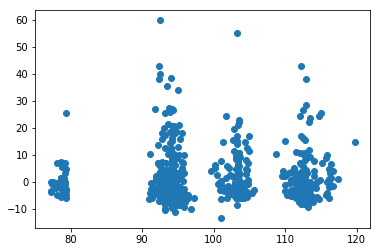

In [856]:
residual = validation_Y-predY_xgb
#plt.scatter(y=residual, x=predY_xgb)
plt.scatter(y=residual, x=predY_xgb)

In [857]:
feat_imp = model_xgb.get_score(importance_type='gain')
importance = pd.DataFrame.from_dict(feat_imp, orient='index')
importance.columns = ['importance']
importance.sort_values(by='importance', ascending=False, inplace=True)

top_feat = importance.index[:50]


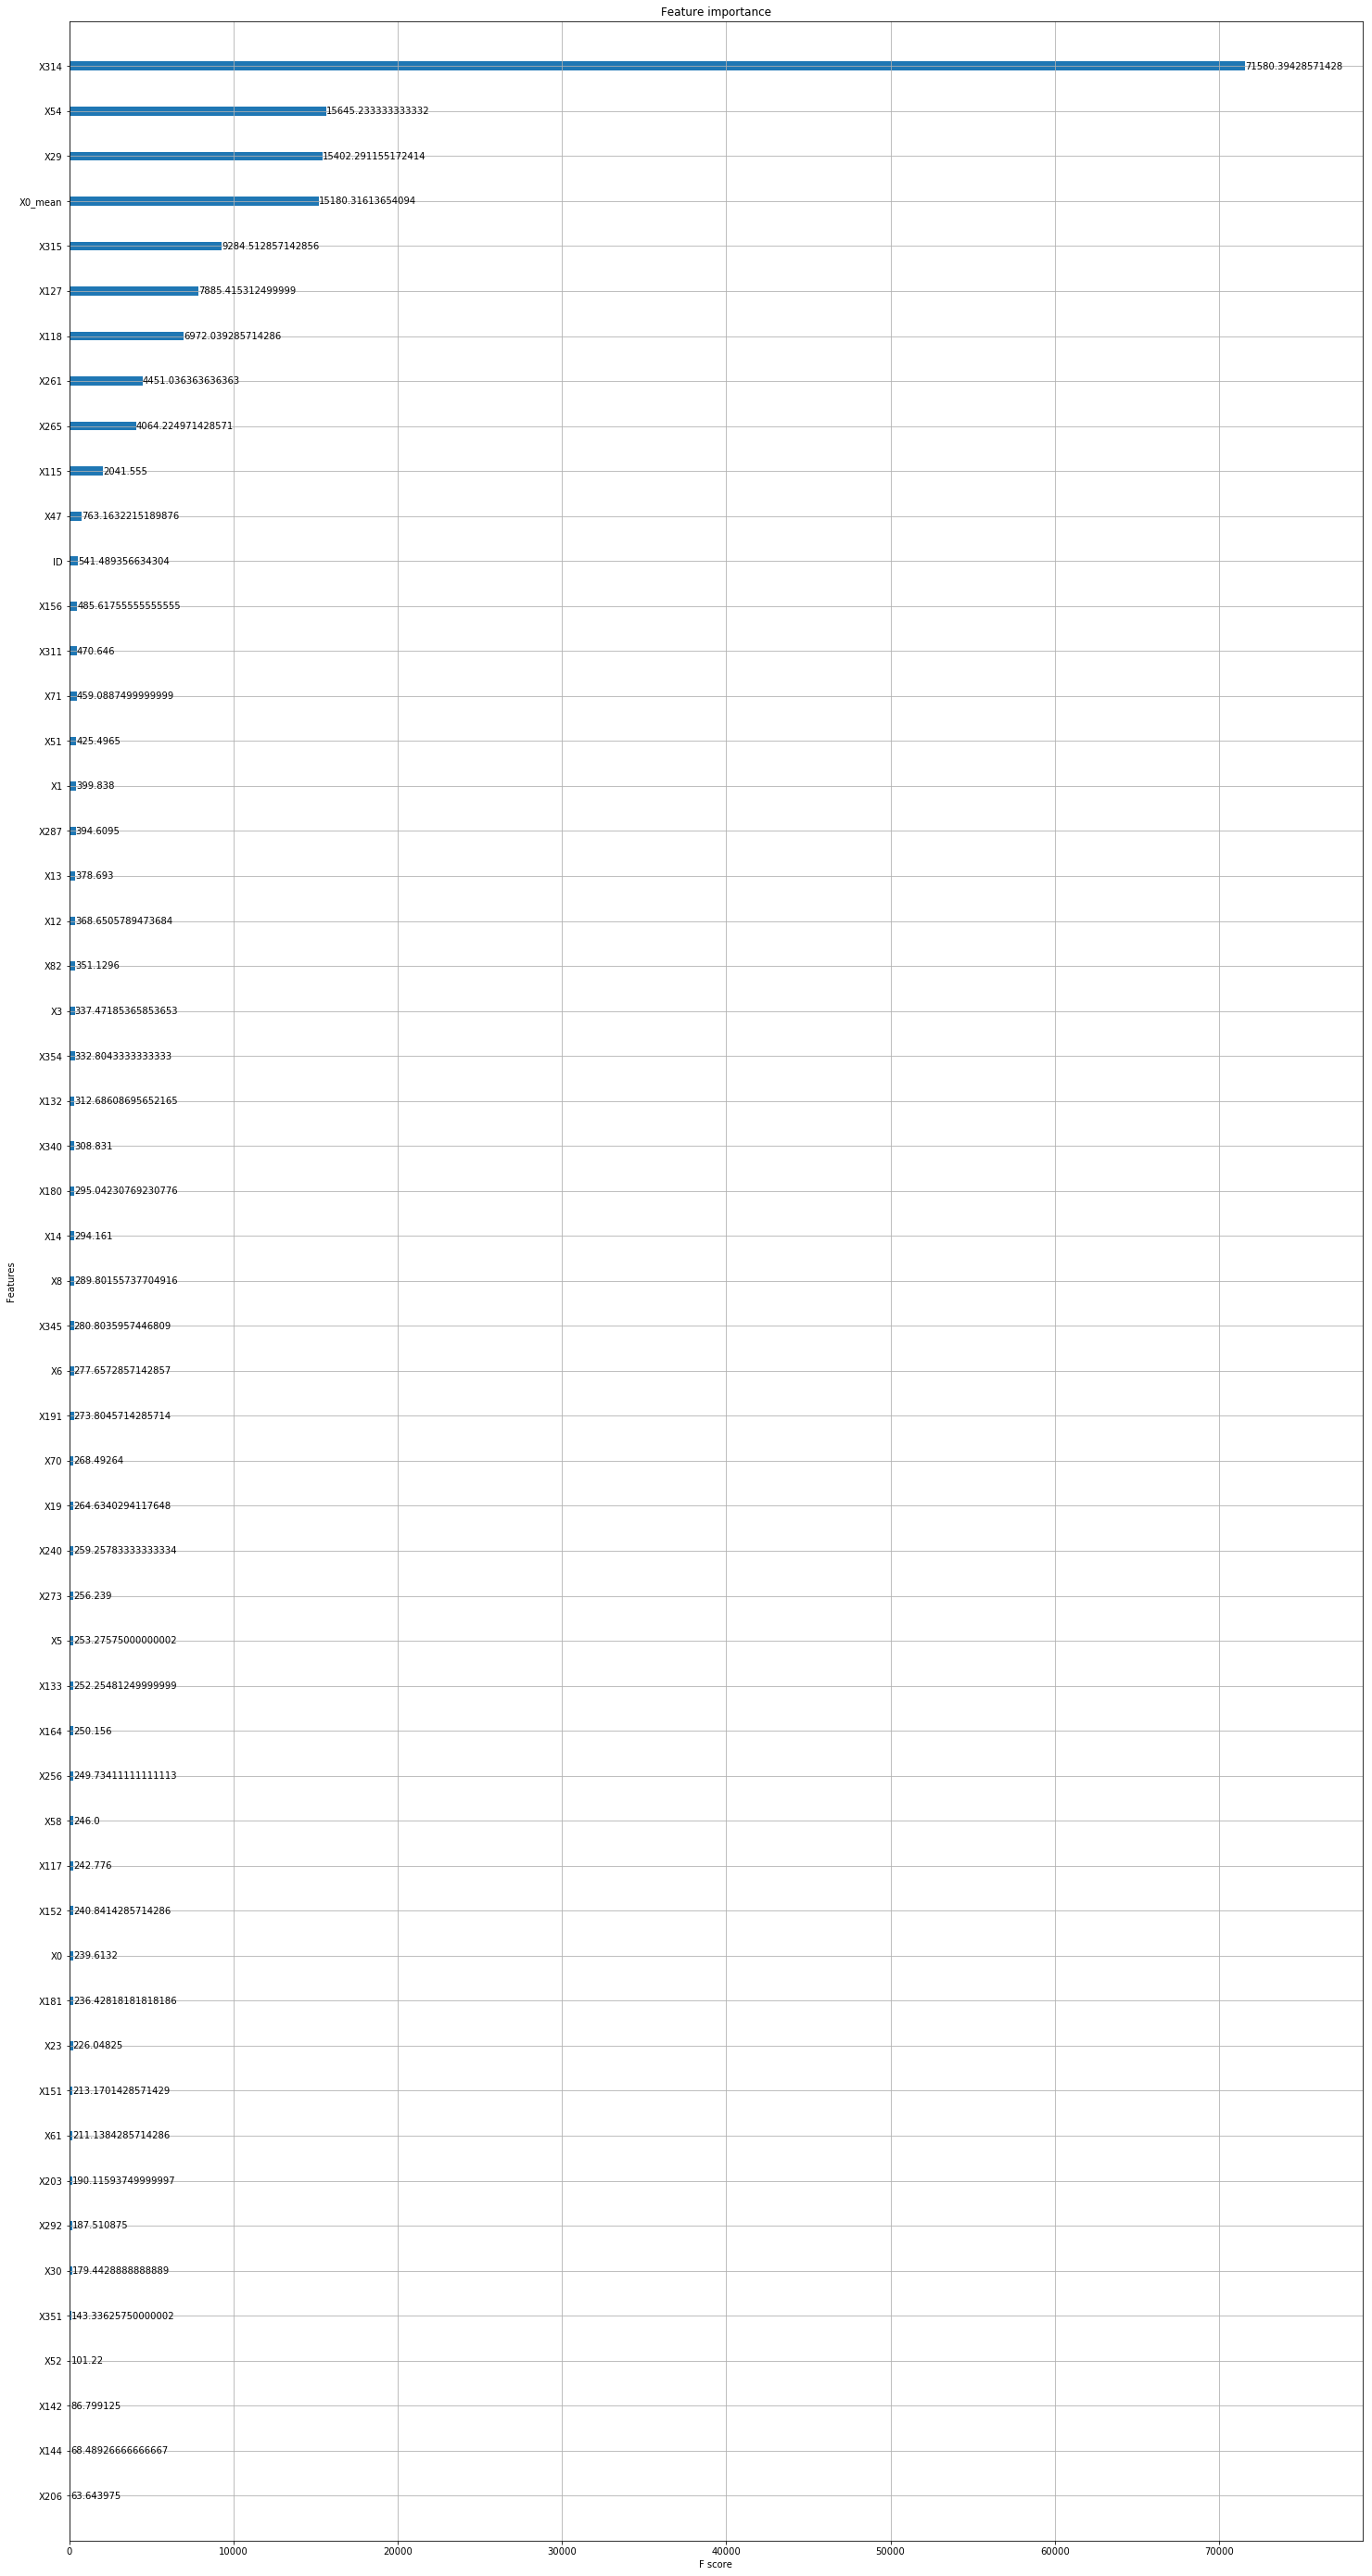

In [858]:
fig, ax = plt.subplots(figsize=(25, 50))
xgb.plot_importance(model_xgb, ax=ax, importance_type='gain')



###  neural network

In [419]:
##Create coef of determination metric
def coeff_determination(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 

    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [546]:
training_Y = training['y'].values
training_X = training.drop('y', axis=1).values

validation_Y = validation['y'].values
validation_X = validation.drop('y', axis=1).values

scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(training_X)
Scaled = scaler.transform(training_X)
scaled_validation_X = scaler.transform(validation_X)

rows, features = Scaled.shape

model_nn = Sequential()
model_nn.add(Dense(features, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(100, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(100, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))


adamax = optimizers.adamax(lr=.0001)
model_nn.compile(loss='mean_squared_error', metrics=[coeff_determination], optimizer=adamax)

In [547]:
weight_file = 'bestweights'
callbacks = [EarlyStopping(monitor='val_loss',patience=20, verbose=0),
            ModelCheckpoint(weight_file, verbose=0, save_best_only=True)]
model_nn.fit(Scaled, training_Y, epochs=100000, batch_size=32, validation_data=(scaled_validation_X, validation_Y), callbacks=callbacks)

Train on 3366 samples, validate on 842 samples
Epoch 1/100000
3366/3366 [==============================] - 2s - loss: 9989.5409 - coeff_determination: -72.9805 - val_loss: 9372.4143 - val_coeff_determination: -68.2316
Epoch 2/100000
3366/3366 [==============================] - 0s - loss: 8096.3431 - coeff_determination: -57.9809 - val_loss: 6128.4485 - val_coeff_determination: -44.1470
Epoch 3/100000
3366/3366 [==============================] - 0s - loss: 3424.4943 - coeff_determination: -23.9269 - val_loss: 885.0500 - val_coeff_determination: -5.3334
Epoch 4/100000
3366/3366 [==============================] - 0s - loss: 352.6764 - coeff_determination: -1.5489 - val_loss: 247.2374 - val_coeff_determination: -0.7287
Epoch 5/100000
3366/3366 [==============================] - 0s - loss: 237.0864 - coeff_determination: -0.6857 - val_loss: 228.1377 - val_coeff_determination: -0.5888
Epoch 6/100000
3366/3366 [==============================] - 0s - loss: 217.1105 - coeff_determination: -0.52

3366/3366 [==============================] - 0s - loss: 63.7086 - coeff_determination: 0.5836 - val_loss: 73.5278 - val_coeff_determination: 0.5362
Epoch 51/100000
3366/3366 [==============================] - 0s - loss: 63.3335 - coeff_determination: 0.5857 - val_loss: 73.4534 - val_coeff_determination: 0.5353
Epoch 52/100000
3366/3366 [==============================] - 0s - loss: 63.1564 - coeff_determination: 0.5952 - val_loss: 73.4154 - val_coeff_determination: 0.5343
Epoch 53/100000
3366/3366 [==============================] - 0s - loss: 63.0812 - coeff_determination: 0.5920 - val_loss: 73.5713 - val_coeff_determination: 0.5382
Epoch 54/100000
3366/3366 [==============================] - 0s - loss: 62.7342 - coeff_determination: 0.5970 - val_loss: 73.0342 - val_coeff_determination: 0.5391
Epoch 55/100000
3366/3366 [==============================] - 0s - loss: 62.6216 - coeff_determination: 0.5971 - val_loss: 73.0266 - val_coeff_determination: 0.5374
Epoch 56/100000
3366/3366 [=====

3366/3366 [==============================] - 0s - loss: 57.8802 - coeff_determination: 0.6246 - val_loss: 70.7899 - val_coeff_determination: 0.5521
Epoch 101/100000
3366/3366 [==============================] - 0s - loss: 57.8159 - coeff_determination: 0.6203 - val_loss: 70.6877 - val_coeff_determination: 0.5535
Epoch 102/100000
3366/3366 [==============================] - 0s - loss: 57.8077 - coeff_determination: 0.6218 - val_loss: 70.7269 - val_coeff_determination: 0.5514
Epoch 103/100000
3366/3366 [==============================] - 0s - loss: 57.5906 - coeff_determination: 0.6238 - val_loss: 70.7321 - val_coeff_determination: 0.5548
Epoch 104/100000
3366/3366 [==============================] - 0s - loss: 57.5798 - coeff_determination: 0.6275 - val_loss: 70.5964 - val_coeff_determination: 0.5551
Epoch 105/100000
3366/3366 [==============================] - 0s - loss: 57.6755 - coeff_determination: 0.6254 - val_loss: 70.7403 - val_coeff_determination: 0.5550
Epoch 106/100000
3366/3366 

3366/3366 [==============================] - 0s - loss: 54.4436 - coeff_determination: 0.6492 - val_loss: 70.8634 - val_coeff_determination: 0.5526
Epoch 150/100000
3366/3366 [==============================] - 0s - loss: 54.9897 - coeff_determination: 0.6405 - val_loss: 70.7454 - val_coeff_determination: 0.5528
Epoch 151/100000
3366/3366 [==============================] - 0s - loss: 54.4196 - coeff_determination: 0.6474 - val_loss: 70.6071 - val_coeff_determination: 0.5530
Epoch 152/100000
3366/3366 [==============================] - 0s - loss: 54.4123 - coeff_determination: 0.6507 - val_loss: 70.6898 - val_coeff_determination: 0.5487
Epoch 153/100000
3366/3366 [==============================] - 0s - loss: 54.5667 - coeff_determination: 0.6411 - val_loss: 71.1162 - val_coeff_determination: 0.5508
Epoch 154/100000
3366/3366 [==============================] - 0s - loss: 54.3886 - coeff_determination: 0.6453 - val_loss: 70.8323 - val_coeff_determination: 0.5524
Epoch 155/100000
3366/3366 

In [548]:
model_nn.load_weights(weight_file, by_name=False)
predY_nn = model_nn.predict(scaled_validation_X, batch_size=128)


r2_score(validation_Y, predY_nn)

0.5512531152982354

#### Linear regression

In [859]:
#training_Y = training['y']
#training_X = training.drop('y',axis=1)

#validation_Y = validation['y']
#validation_X = validation.drop('y',axis=1)




model_lm = linear_model.Lasso(alpha=1.2, normalize=True, fit_intercept=False, max_iter=100000)
model_lm.fit(training_X,training_Y)

Lasso(alpha=1.2, copy_X=True, fit_intercept=False, max_iter=100000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [860]:
predY_lm = model_lm.predict(validation_X)
r2_score(validation_Y, predY_lm)

0.55690350709188108

#### SVM

In [861]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(training_X)
Scaled = pd.DataFrame(scaler.transform(training_X),columns=list(training_X))
scaled_validation_X = pd.DataFrame(scaler.transform(validation_X),columns=list(training_X))


model_svm = svm.SVR(kernel='rbf', C=550, epsilon=0, max_iter=1000000)
model_svm.fit(Scaled,training_Y)

SVR(C=550, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma='auto',
  kernel='rbf', max_iter=1000000, shrinking=True, tol=0.001, verbose=False)

In [862]:
predY_svm = model_svm.predict(scaled_validation_X)
r2_score(validation_Y, predY_svm)

0.53121264923961808

#### random forest

In [863]:
model_rf = RandomForestRegressor(n_jobs=3, n_estimators=3000, max_depth=9, max_features='sqrt', min_samples_leaf=1)
model_rf.fit(training_X, training_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [864]:
predY_rf = model_rf.predict(validation_X)
r2_score(validation_Y, predY_rf)

0.56138088151416821

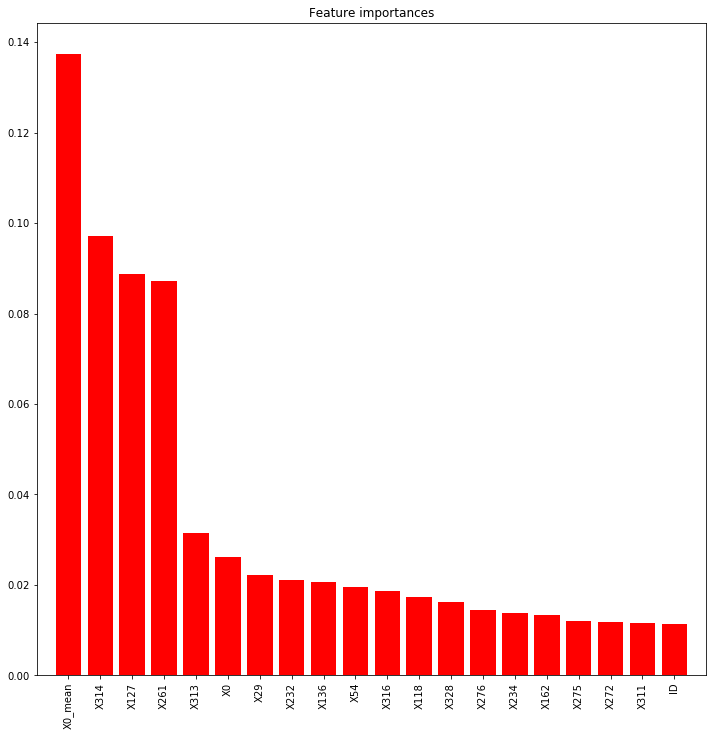

In [633]:
feat_names = training_X.columns.values
## plot the importances ##
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

#### PCA with ridge

In [865]:
n_components = [5, 10, 15, 30, 50]
alpha = [.1, .5, 1, 3, 5]
#normalize=True, fit_intercept=False, max_iter=100000


pipe_dict = dict(pca__n_components=n_components,
                linear__alpha=alpha,
                linear__max_iter=[1000000])


regr = linear_model.Lasso()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', regr)])

model_pca_lasso = GridSearchCV(pipe,pipe_dict, cv=5)

model_pca_lasso.fit(training_X, training_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [5, 10, 15, 30, 50], 'linear__alpha': [0.1, 0.5, 1, 3, 5], 'linear__max_iter': [1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [866]:
model_pca_ridge.best_estimator_.named_steps['pca'].n_components

10

In [867]:
model_pca_ridge.best_estimator_.named_steps['linear'].alpha

1.0

In [868]:
predY_pca_lasso = model_pca_lasso.predict(validation_X)
r2_score(validation_Y, predY_pca_lasso)

0.55880247755168488

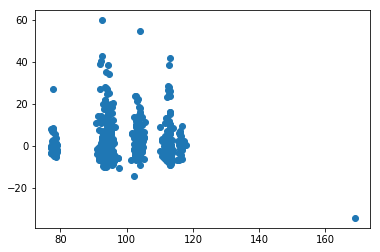

In [869]:
residual = validation_Y-predY_pca_lasso
plt.scatter(y=residual, x=predY_pca_lasso)

### Final and submission

In [ ]:
train_Y = train['y']
train_X = train.drop('y',axis=1)

testing_final = testing.values

#### nerual net sub

In [ ]:
rows, features = train_X.shape

model_nn_final = Sequential()
model_nn_final.add(Dense(features, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
#model_nn_final.add(Dropout(.6,))
model_nn_final.add(Dense(50, activation='relu', bias_initializer='RandomNormal'))
model_nn_final.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))

model_nn_final.compile(loss='mean_squared_error', optimizer='adam')

model_nn_final.load_weights(weight_file, by_name=False)

predY_nn_final = model_nn.predict(testing_final, batch_size=128)

In [ ]:
submission_nn = pd.DataFrame()
submission_nn['ID'] = testing['ID']
submission_nn['y'] = predY_nn_final


sub_file_nn = 'submission-nn.csv'
submission_nn.to_csv(sub_file_nn, index=False)

#### lm sub

In [875]:
model_lm_final = linear_model.Lasso(alpha=1.2, normalize=True, fit_intercept=False, max_iter=100000)
model_lm_final.fit(train_final_X,train_final_Y)

Lasso(alpha=1.2, copy_X=True, fit_intercept=False, max_iter=100000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [876]:
predY_lm_final = model_lm_final.predict(testing_final)

submission_lm = pd.DataFrame()
submission_lm['ID'] = testing_ID
submission_lm['y'] = predY_lm_final



#### svm sub

In [402]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_final_X)
Scaled_final = pd.DataFrame(scaler.transform(train_final_X),columns=list(train_final_X))
scaled_testing = pd.DataFrame(scaler.transform(testing_final),columns=list(train_final_X))


model_svm_final = svm.SVR(kernel='rbf', C=550, epsilon=0, max_iter=1000000)
model_svm_final.fit(Scaled_final,train_final_Y)

SVR(C=550, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma='auto',
  kernel='rbf', max_iter=1000000, shrinking=True, tol=0.001, verbose=False)

In [403]:
predY_svm_final = model_svm_final.predict(scaled_testing)

submission_svm = pd.DataFrame()
submission_svm['ID'] = testing_ID
submission_svm['y'] = predY_svm_final

#### random forest sub

In [637]:
model_rf_final = RandomForestRegressor(n_jobs=3, n_estimators=3000, max_depth=9, max_features='sqrt', min_samples_leaf=1)
model_rf_final.fit(train_final_X, train_final_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [638]:
predY_rf_final = model_rf_final.predict(testing_final)

submission_rf = pd.DataFrame()
submission_rf['ID'] = testing_ID
submission_rf['y'] = predY_rf_final

#### pca with lasso final

In [695]:
model_pca_lasso_final = GridSearchCV(pipe,pipe_dict, cv=5)

model_pca_lasso_final.fit(train_final_X, train_final_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [5, 10, 15, 30, 50], 'linear__alpha': [0.1, 0.5, 1, 3, 5], 'linear__max_iter': [1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [700]:
predY_pca_lasso_final = model_pca_lasso_final.predict(testing_final)

submission_pca_lasso = pd.DataFrame()
submission_pca_lasso['ID'] = testing_ID
submission_pca_lasso['y'] = predY_pca_lasso_final


sub_file_pca_lasso = 'submission-pca_lasso.csv'
submission_pca_lasso.to_csv(sub_file_pca_lasso, index=False)

#### xgboost sub

In [839]:
##Add X0 mean feature for testing
X0_mean_dict = train.groupby(by='X0').mean()['y'].to_dict()

train_index = train.index.values
testing_index = testing.index.values
train.loc[:,'X0_mean'] = 'NaN'
testing.loc[:,'X0_mean'] = 'NaN'

for idx in train_index:
    train.loc[idx, 'X0_mean'] = X0_mean_dict[train.loc[idx,'X0']] 
    
for idx in testing_index:
    testing.loc[idx,'X0_mean'] = X0_mean_dict.get(testing.loc[idx,'X0'])
    
train.loc[:,'X0_mean'] = pd.to_numeric(train.loc[:,'X0_mean'])
testing.loc[:,'X0_mean'] = pd.to_numeric(testing.loc[:,'X0_mean'])
testing.loc[testing.loc[testing['X0_mean'].isnull()].index,'X0_mean'] = train['X0_mean'].mean()





train_final_Y = train['y']
train_final_X = train.drop('y',axis=1)
#train_final_X = train[top10]
#testing_final = testing[top10]
testing_final = testing

trainXGB = xgb.DMatrix(train_final_X, label=train_final_Y)
testingXGB = xgb.DMatrix(testing_final)

model_xgb_final = xgb.train(best_params,trainXGB, num_boost_round = best_params['n_estimators'])

predY_xgb_final = model_xgb_final.predict(testingXGB)



submission_xgb = pd.DataFrame()
submission_xgb['ID'] = testing_ID
submission_xgb['y'] = predY_xgb_final



sub_file_xgb = 'submission-xgb.csv'
submission_xgb.to_csv(sub_file_xgb, index=False)

In [873]:
testing_final.drop('X136',axis=1,inplace=True)

#### combined submission

In [877]:
submission_combo = submission_xgb
submission_combo['y_lm'] = submission_lm['y']
#submission_combo['y_svm'] = submission_svm['y']
#submission_combo['y_rf'] = submission_rf['y']
#submission_combo['y_pca_lasso'] = submission_pca_lasso['y']

submission_combo['y_combo'] = (submission_combo.y.values+submission_combo.y_lm.values)/2
#submission_combo['y_combo'] = np.cbrt((submission_combo.y.values*submission_combo.y_lm.values*submission_combo.y_pca_lasso.values))

submission_combo.drop(['y','y_lm'], axis=1, inplace=True)
submission_combo.rename(columns={'y_combo': 'y'}, inplace=True)


sub_file_combo = 'submission_combo.csv'
submission_combo.to_csv(sub_file_combo, index=False)

In [878]:
submission_combo['y']

0        79.484898
1        94.651582
2        79.482428
3        79.220165
4       113.321333
5        94.340292
6       113.535843
7        95.086897
8       117.097481
9        95.649614
10      117.093288
11      104.693374
12       95.537799
13       95.673685
14      105.668563
15       95.537360
16      117.092519
17       95.537140
18       95.960427
19       94.725188
20       95.536481
21       95.119805
22       95.464150
23       95.118926
24       94.083529
25      116.825686
26      103.992801
27      104.008541
28       94.468036
29       79.912716
30      113.139214
31       94.284209
32      104.373953
33       95.653271
34      103.056456
35      113.047551
36       95.183555
37      105.104436
38       95.652062
39       95.897666
40      103.207441
41       95.072581
42      103.086575
43      105.647437
44      116.594360
45       95.044722
46      105.102459
47       94.460548
48      103.993772
49      113.026628
50       94.934829
51      113.165369
52       94.